In [1]:
import os
import sys
import json
from scipy import stats
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, ShuffleSplit
from tqdm import tqdm
import warnings
import matplotlib as mpl
import plot_utils

warnings.filterwarnings('ignore', 'invalid value encountered in true_divide')

## Settings

In [2]:
TEXTWIDTH = 6.7261  # in
DPI = 360

In [3]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [4]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6)

## Colors

In [5]:
ot1_color = 'tab:green'
palette_tcrs = {'OT1': ot1_color, 
                'OTI': ot1_color, 
                'OT-I': ot1_color, 
                'Educated': 'tab:orange',
                'Naive': 'tab:blue',
                'Naïve': 'tab:blue',
                'Human': 'Firebrick',
                'CMV': 'darkcyan'
               }

color_random ='silver'
color_mice = 'silver'

palette_cmv = 'GnBu'

color_mice = 'silver'
color_cdr3 = 'violet'
cmap_distances = 'viridis_r'

## Load Data

In [6]:
def compute_classification_metrics(g):
    return pd.Series({
        'AUC': (
            metrics.roc_auc_score(g['is_activated'], g['pred'])
            if np.isfinite(g['pred']).all() and 0 < g['is_activated'].mean() < 1
            else np.nan
        ),
        'APS': (
            metrics.average_precision_score(g['is_activated'], g['pred'])
            if np.isfinite(g['pred']).all()
            else np.nan
        ),
    })

In [7]:
def compute_regression_metrics(g):
    return pd.Series({
        'MAE': g['abserr'].mean(),
        'R2': metrics.r2_score(g['activation'], g['pred']),
        'Pearson': g['activation'].corr(g['pred'], method='pearson'),
        'Spearman': g['activation'].corr(g['pred'], method='spearman'),
    })

In [8]:
def load_classification_data():
    fname = f'../activation-prediction/results'
    pdf = pd.read_csv(f'{fname}/NLVPMVATV_tcr_stratified_classification_performance.csv.gz')
    
    pdf = pdf[pdf['normalization']=='none']
    pdf = pdf[pdf['threshold']==40]
    pdf = pdf[pdf['reduced_features']]
    
    pdf = pdf.query('mut_pos >= 0')
    pdf = pdf.groupby([
        'normalization', 'tcr'
    ]).filter(lambda g: 0 < g['is_activated'].sum() < len(g) - 1)

    pdf['Repertoire'] = 'CMV'

    df_metrics = pdf.groupby(['tcr'], as_index=False).apply(compute_classification_metrics).reset_index()

    df_metrics['Repertoire'] = 'CMV'
    return pdf, df_metrics
pdf_classification, df_classification_metrics = load_classification_data()

In [9]:
def load_regression_data():
    fname = f'../activation-prediction/results'
    pdf = pd.read_csv(f'{fname}/NLVPMVATV_tcr_stratified_regression_performance.csv.gz')
    
    pdf = pdf[pdf['normalization']=='none']
    pdf = pdf.query('mut_pos >= 0')
    pdf['Repertoire'] = 'CMV'
    pdf['abserr'] = pdf['err'].abs()
    df_metrics = pdf.groupby(['tcr'], as_index=False).apply(compute_regression_metrics).reset_index()

    df_metrics['Repertoire'] = 'CMV'
    return pdf, df_metrics
pdf_regression, df_regression_metrics = load_regression_data()

### Baseline Data

In [10]:
def load_ergo_data(db, suffix='_cmv', full=True):
    if full:
        #df_normal = load_ergo_data(db, '', full=False)
        df_cmv = load_ergo_data(db, '_cmv', full=False)
        return df_cmv #pd.concat([df_normal, df_cmv])
    path_res = f'../baseline/results_pred/ergo_{db}{suffix}.csv'
    prediction_ergo = pd.read_csv(path_res, index_col=0)
    prediction_ergo = prediction_ergo[prediction_ergo['Peptide'] != 'NLVPMVATV']
    return prediction_ergo

In [11]:
def load_imrex_data(suffix='_cmv', full=True):
    if full:
        # df_normal = load_imrex_data('', full=False)
        df_cmv = load_imrex_data('_cmv', full=False)
        return df_cmv
    path_imrex = f'../baseline/results_pred/imrex{suffix}.csv'
    prediction_imrex = pd.read_csv(path_imrex, index_col=0)
    prediction_imrex = prediction_imrex[prediction_imrex['antigen.epitope'] != 'NLVPMVATV']
    return prediction_imrex

In [12]:
def get_auc_per_tcr(data, tcr, y_true, col_pred):
    data_tmp = data[data['tcr'] == tcr]
    y_pred = data_tmp[col_pred]
    auc_score = metrics.roc_auc_score(y_true['is_activated'], y_pred)
    return auc_score

def get_spearman_per_tcr(data, tcr, y_true, col_pred):
    data_tmp = data[data['tcr'] == tcr].copy()
    data_tmp['activation_true'] = y_true['activation'].values
    auc_score = data_tmp['activation_true'].corr(data_tmp[col_pred], method='spearman')
    return auc_score

def load_baseline_data(metric='AUC'):
    prediction_ergo_vdjdb = load_ergo_data('vdjdb')
    prediction_ergo_mcpas = load_ergo_data('mcpas')
    prediction_imrex = load_imrex_data()
    
    prediction_ours = pdf_classification[pdf_classification['tcr'].isin(prediction_ergo_vdjdb['tcr'].unique())]
    
    metric_func = get_auc_per_tcr
    if metric == 'Spearman':
        metric_func = get_spearman_per_tcr
        predictin_outs = pdf_regression[pdf_regression['tcr'].isin(prediction_ergo_vdjdb['tcr'].unique())]
        
    performance = []
    for tcr in prediction_ergo_vdjdb['tcr'].unique():
        if tcr in ['LR_OTI_1', 'LR_OTI_2']:
            continue
        y_true = prediction_ours[prediction_ours['tcr'] == tcr]#['is_activated']
        
        scores_ergo_mcpas = metric_func(prediction_ergo_mcpas, tcr, y_true, col_pred='Score')
        scores_ergo_vdjdb = metric_func(prediction_ergo_vdjdb, tcr, y_true, col_pred='Score')
        scores_imrex = metric_func(prediction_imrex, tcr, y_true, col_pred='prediction_score')
        scores_ours = metric_func(prediction_ours, tcr, y_true, col_pred='pred')
        performance.append([tcr, scores_ergo_mcpas, scores_ergo_vdjdb, scores_imrex, scores_ours])
    performance = pd.DataFrame(performance, columns=['tcr', 'ergo-mcpas', 'ergo-vdjdb', 'imrex', 'P-TEAM'])

    performance = performance.set_index('tcr')
    order = list(performance.index)
    performance = performance.reindex(order)
    return performance

performance_baseline = load_baseline_data()
performance_baseline_regression = load_baseline_data('Spearman')

## Test: random TCR

In [13]:
import random

In [14]:
def read_cmv_data():
    path_in = '../data/Affinity_prediction_cmv.xlsx'
    sheet = 'Mean'
    df = pd.read_excel(path_in, sheet)
    
    df_pep = pd.read_excel(path_in, 'peptides',)
    df['Mutated_position'] = df_pep['Mutated Position']
    df['Mutated AA'] = df_pep['Amino acid']
    
    df['Mutated_position'] = df['Mutated_position'].replace({'NLVPMVATV': 0})
    df['Mutated AA'] = df['Mutated AA'].replace({'original': 0})
    df = df[[el for el in df.columns if not el.startswith('Unnamed')]]
    
    df.index = df['Mutated_position'].astype(str) + '_' + df['Mutated AA'].astype(str)
    df = df.drop(columns=['Mutated_position', 'Mutated AA', 'Peptide_ID'])
    #tcrs = df.columns[4:11]
    #df = df[tcrs]
    df = df.reindex(df.index[1:].tolist() + df.index[:1].tolist())
    sorted_columns = df.loc['0_0'].sort_values(ascending=False)
    df = df[sorted_columns.index]
    df.columns = [f'TCR{el.replace("_", "-")}' for el in df.columns]
    return df
data_cmv_norm = read_cmv_data()

In [15]:
tcrs_eval = df_classification_metrics['tcr'].unique()
data_cmv_norm = read_cmv_data()
data_cmv_norm.columns = [el.upper() for el in data_cmv_norm.columns]
data_cmv_norm = data_cmv_norm[[el for el in data_cmv_norm.columns if el in tcrs_eval]]
data_cmv_norm = data_cmv_norm[:-1]
data_cmv_norm_bin = data_cmv_norm > 40.0

In [16]:
random.seed(0)
df_rdm = {
    'tcr': [],
    'AUC': [],
    'APS': [],
    'Spearman': [],
}
for tcr in tcrs_eval:
    label = data_cmv_norm_bin[tcr].values
    random_tcr = data_cmv_norm_bin[[el for el in data_cmv_norm_bin.columns if el!=tcr]].values
    random_tcr = random_tcr[:, random.randint(0, random_tcr.shape[1]-1)]
    auc = metrics.roc_auc_score(label, random_tcr)
    aps = metrics.average_precision_score(label, random_tcr)
    
    df_rdm['tcr'].append(tcr)
    df_rdm['AUC'].append(auc)
    df_rdm['APS'].append(aps)
    
    label = data_cmv_norm[tcr].values
    random_tcr = data_cmv_norm[[el for el in data_cmv_norm.columns if el!=tcr]].values
    random_tcr = random_tcr[:, random.randint(0, random_tcr.shape[1]-1)]
    df_tmp = pd.DataFrame({'label': label, 'rdm': random_tcr})
    spearman =  df_tmp['label'].corr(df_tmp['rdm'], method='spearman')
    df_rdm['Spearman'].append(spearman)
    
df_rdm = pd.DataFrame(df_rdm)
df_rdm[['AUC', 'APS', 'Spearman']].mean()

AUC         0.697812
APS         0.414635
Spearman    0.586879
dtype: float64

In [17]:
df_classification_metrics[['AUC', 'APS']].mean()

AUC    0.884059
APS    0.739289
dtype: float64

In [18]:
df_regression_metrics[['Spearman']].mean()

Spearman    0.787549
dtype: float64

## Statistical testing

In [19]:
def pval_2_asterix(val):
    if val < 0.0001:
        return '****'
    if val < 0.001:
        return '***'
    if val < 0.01:
        return '**'
    if val < 0.05:
        return '*'
    return ''

In [20]:
performance_baseline.mean()

ergo-mcpas    0.553407
ergo-vdjdb    0.478077
imrex         0.514067
P-TEAM        0.884059
dtype: float64

In [21]:
p_values_baseline = {}
for col in ['ergo-mcpas', 'ergo-vdjdb', 'imrex']:
    res = stats.ttest_rel(performance_baseline[col], performance_baseline['P-TEAM'])
    p_values_baseline[col] = (res[1], pval_2_asterix(res[1]))
p_values_baseline

{'ergo-mcpas': (1.6366522121612228e-10, '****'),
 'ergo-vdjdb': (9.093256371156066e-13, '****'),
 'imrex': (1.1000668429790036e-10, '****')}

## Structural modelling

In [22]:
def load_data_permutation_importance(epitope='NLVPMVATV'):
    fname = f'../activation-prediction/results/{epitope}_tcr_stratified_permutation_importance_regression.csv.gz'
    pdf = pd.read_csv(fname)

    mdf =  pdf.groupby(['tcr', 'group', 'shuffle']).apply(lambda g: pd.Series({
        'mae': g['abserr'].mean(),
        'r2': metrics.r2_score(g['activation'], g['pred']),
        'pearson': g['activation'].corr(g['pred'], method='pearson'),
        'spearman': g['activation'].corr(g['pred'], method='spearman'),
    })).reset_index().drop(columns='shuffle')
    

    ddf = mdf.melt(['tcr', 'group']).merge(
        mdf[
            mdf['group'] == 'all'
        ].drop(columns='group').melt('tcr', value_name='base').drop_duplicates(),
        on=['tcr', 'variable']
    )
    ddf['diff'] = ddf['value'] - ddf['base']
    ddf['rel'] = ddf['value'] / ddf['base'] - 1  # positive = increase
    ddf['item'] = ddf['group'].str.split('_').str[0]
    ddf['is_educated'] = np.where(
        ddf['tcr'].str.startswith('ED') | ddf['tcr'].str.startswith('R') | ddf['tcr'].str.startswith('TCR'),
        'Educated', 'Naive'
    )
    permutation_data = ddf[(
        ddf['is_educated'] == "Educated"
    ) & (
        ddf['variable'] == 'spearman'
    ) & (
        ddf['group'].str.startswith('pos_')
          | ddf['group'].isin(['cdr3', 'all'])
    )].rename(columns={
        'value': 'Spearman', 'group': 'Permutation'
    })
    permutation_data = permutation_data.replace({
        'pos_0': 'P1', 'pos_1': 'P2', 'pos_2': 'P3', 'pos_3': 'P4',
        'pos_4': 'P5', 'pos_5': 'P6', 'pos_6': 'P7', 'pos_7': 'P8', 'pos_8': 'P9',
        'cdr3': 'CDR3', 'all': '-'
    })
    return permutation_data
df_importance_cmv = load_data_permutation_importance('NLVPMVATV')

In [23]:
def load_available_visualisations(repertoire='cmv'):
    path_in = f'figures/3dModel/{repertoire}'
    files = os.listdir(path_in)
    files = [el.split('_')[0] for el in files]
    return files

vis_names_cmv = load_available_visualisations('cmv')

In [24]:
def load_3D_distances(epitope='SIINFEKL'):
    path_in = '../results/model3d/'
    path_in += 'cmv'    
    tcrs = vis_names_cmv
    
    distances_alpha = {tcr: pd.read_csv(f'{path_in}/{tcr}_{epitope}_alpha.csv', index_col=0) for tcr in tcrs}
    distances_beta = {tcr: pd.read_csv(f'{path_in}/{tcr}_{epitope}_beta.csv', index_col=0) for tcr in tcrs}
    
    min_epitope_distances = {}
    for tcr in distances_alpha.keys():
        min_distances = np.stack([distances_alpha[tcr].values.min(axis=1), distances_beta[tcr].values.min(axis=1)])
        min_distances = np.min(min_distances, axis=0)
        min_epitope_distances[tcr] = min_distances
    return min_epitope_distances

dists_cmv = load_3D_distances('NLVPMVATV')

## Plotting Functions - Across Prediction

In [25]:
def plot_auc(data, ax, ylabel=None, xlabel=None, metric_func=metrics.roc_curve, metric_name='AUC'):
    if metric_func == metrics.roc_curve:
        ax.plot([0, 1], [0, 1], c=color_random, linestyle='--')
    
    groups = data.groupby('tcr')
    for i, (tcr, g) in enumerate(groups):
        x, y, _ = metric_func(g['is_activated'], g['pred'])
        kwargs = {
            'c': palette_tcrs[g['Repertoire'].values[0]],
            'alpha': 0.3 if tcr != 'OTI' else 1.0,
            'label': 'OTI_PH' if tcr == 'OTI' else 'Educated' if 'ED' in tcr else 'Naive',
            'linewidth': 0.5
        }
        if metric_func == metrics.roc_curve:
            ax.plot(x, y, **kwargs)
        else:
            ax.plot(y, x, **kwargs)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(False)
    if ylabel:
        ax.set_ylabel(ylabel, labelpad=0)
    else:
        ax.set_yticklabels([])
    if xlabel:
        ax.set_xlabel(xlabel, labelpad=0)
    else:
        ax.set_xticklabels([])

    df_mean = df_classification_metrics[df_classification_metrics['tcr'].isin(data['tcr'])]
    mean = df_mean[metric_name].mean()
    ax.set_title(f'Avg {metric_name}: {mean:.3f}', pad=-2, size='medium')
    sb.despine(ax=ax)
    ax.tick_params(axis='both', length=0, pad=3)

In [26]:
def plot_metric_boxplot(metrics, ax):   
    bp_data = df_classification_metrics[['tcr', 'Repertoire'] + ['APS', 'AUC']].copy()
    bp_data_reg = df_regression_metrics[['tcr', 'Repertoire'] + ['Spearman']].copy()
    bp_data['Spearman'] = bp_data_reg['Spearman']
    bp_data = bp_data.melt(['tcr', 'Repertoire'], value_name='Value', var_name='Metric')
    
    bp_data = bp_data[bp_data['Metric'].isin(metrics)]
    sb.boxplot(
        data=bp_data,
        y='Value', hue='Repertoire', ax=ax, fliersize=1,
        x='Metric', hue_order=['CMV'], palette=palette_tcrs,
        #color='#ffffffff'
    )
    
    ax.set_ylabel('Metric Score', labelpad=2)
    ax.set_xlabel(ax.get_xlabel(), labelpad=0)
    ax.legend().remove()
    ax.grid(False)
    sb.despine(ax=ax)
    ax.tick_params(axis='both', length=0, pad=3)

In [27]:
def tcr_to_color(tcr):
    if tcr.startswith('ED'):
        return palette_tcrs['Educated']
    elif tcr == 'OTI':
        return palette_tcrs['OT1']
    return palette_tcrs['Naive']

In [28]:
order = ['imrex', 'ergo-vdjdb', 'ergo-mcpas', 'P-TEAM']
def plot_baseline_data(data, ax, metric='AUC'):
    data['tcr'] = data.index
    data = data.melt(['tcr'], value_name=metric, var_name='Model')
    data['color'] = [palette_tcrs['CMV']] * len(data)

    plot_base = sb.swarmplot(data=data, x='Model', y=metric, hue='tcr', size=2,
                           order=order,
                           palette=data['color'], ax=ax)
    plot_base.set_ylabel(metric, labelpad=2)
    plot_base.set_xlabel(ax.get_xlabel(), labelpad=0)

    plot_base.set_xticklabels(['ImRex', 'ERGO-II\nVDJdb', 'ERGO-II\nMcPAS', 'P-TEAM'])
    [label.set_fontweight('bold') for label in ax.get_xticklabels() if label.get_text()=='P-TEAM']
    
    ax.get_legend().remove()
    plot_base.set(xlabel=None)
    sb.despine(ax=ax)
    ax.grid(False)   
    ax.tick_params(axis='both', length=0, pad=3)

In [29]:
def plot_significance(ax):   
    ax.set_xlim([0.5, 4.5])
    ax.set_ylim([0, 3])
    for i, model in enumerate(order[:-1]):
        p_sign = p_values_baseline[model][1]
        if p_sign == '':
            continue
        i_rev = 2-i
        ax.annotate(p_sign, xy=(2.5+i/2, 1+i_rev), xytext=(2.5+i/2, 1+i_rev-0.55), #xycoords='axes fraction', 
                ha='center', va='bottom', weight='bold',
                arrowprops=dict(arrowstyle=f'-[, widthB={2.*(i_rev+1)}, lengthB=0.4', lw=0.5, color='k'))
    
    sb.despine(ax=ax, left=True, bottom=True)
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

## Plotting Functions - Structural

In [30]:
def plot_permutation_importance_base(data, ax, palette, do_heading=False):
    median_base = data[data['Permutation']=='-']['Spearman'].median()
    ax.axhline(median_base, linestyle='dashed', color='gray', linewidth=1,
              clip_on=False, xmax=1.2)
    
    vmin = data['Spearman'].min() - 0.1
    data = data[data['item']!='pos'].copy()
    data['Permutation'] = data['Permutation'].replace('CDR3', '+')
    g = sb.boxplot(
        data=data,
        x='Permutation',
        y='Spearman',
        palette=palette,
        zorder=2,
        showmeans=True,
        notch=False,
        meanprops={'mfc': 'k', 'mec': 'k', 'markersize': 2},
        ax=ax,
        fliersize=2,
    )
    g.set(ylim=(vmin, 1), ylabel=None, xlabel=None)
    
    ax.grid(False)
    sb.despine(ax=ax)
    ax.set_ylabel('Spearman', labelpad=2)
    ax.set_xlabel('Shuffling TCRs' if do_heading else '', labelpad=2)
    ax.xaxis.set_label_position('top')
    ax.tick_params(axis='x', which='major', pad=-2)
    ax.tick_params(axis='y', which='major', pad=3, length=0)

In [31]:
def plot_permutation_importance_position(data, ax, palette, do_heading=False):
    median_base = data[data['Permutation']=='-']['Spearman'].median()
    ax.axhline(median_base, linestyle='dashed', color='gray', linewidth=1, zorder=-99)
    
    vmin = data['Spearman'].min() - 0.1
    data = data[data['item']=='pos']
    g = sb.boxplot(
        data=data,
        x='Permutation',
        y='Spearman',
        palette=palette,
        zorder=2,
        showmeans=True,
        notch=False,
        meanprops={'mfc': 'k', 'mec': 'k', 'markersize': 2},
        ax=ax,
        fliersize=2,
    )
    g.set(ylim=(vmin, 1), ylabel=None, xlabel=None)
    
    ax.grid(False)
    sb.despine(ax=ax, left=True)
    ax.set_yticklabels([])
    ax.set_xlabel('Shuffling at Epitope Positions' if do_heading else '', labelpad=2)
    ax.xaxis.set_label_position('top')
    ax.tick_params(axis='x', which='major', pad=-2)

In [32]:
def plot_3d_structures(ax, tcr, do_legend=False):
    def get_crop_border(axis, direction):
        axis_sum = img[:, :, 3].sum(axis=axis)
        indices = np.where(axis_sum>0)[0]
        return direction(indices)
    rep = 'cmv'
    path_tcr = f'figures/3dModel/{rep}/{tcr}_NLVPMVATV.png'
    img = mpl.image.imread(path_tcr)
    
    x0 = get_crop_border(0, min)
    x1 = get_crop_border(0, max)
    y0 = get_crop_border(1, min)
    y1 = get_crop_border(1, max)
    img = img[y0:y1, x0:x1]
    
    ax.imshow(img)
    ax.grid(False)
    sb.despine(ax=ax, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])
    if do_legend:
        handles = [mpl.lines.Line2D([], [], color=color, ls='', marker='_') 
                  for name, color in colors_structures.items()]
        ax.legend(handles, list(colors_structures.keys()), 
                  loc='upper right', bbox_to_anchor=(1.35, 1.15),
                  prop={'size': 'small'})  

In [33]:
def plot_3d_distances(ax, tcr, vmin=None, vmax=None, do_labels=True, legend_top=True):
    len_epitope = 9 if tcr.startswith('R') else 8  
    dists = dists_cmv
    
    if not vmin is None:
        vmin = min([d.min() for d in dists.values()])
        vmax = max([d.max() for d in dists.values()])
    if not 'avg' in tcr:
        dist = dists[tcr].reshape((1, -1))
    else:
        dist = np.vstack(list(dists.values())).mean(axis=0).reshape((1, -1))
        if tcr.startswith('R'):
            dist = np.delete(dist, 1, axis=-1)
    x_labels = [f'P{i + 1}' for i in range(len_epitope)] if do_labels else []
    plot = sb.heatmap(dist, square=not 'avg' in tcr,
                       vmin=vmin, vmax=vmax, cmap=cmap_distances,
                       xticklabels=x_labels, cbar=False, ax=ax)
    tcr = tcr if tcr != 'OT1' else 'OT-I'
    tcr = tcr.upper() if not 'avg' in tcr else 'Distance averaged over TCRs'
    plot.set_xlabel(tcr.replace('TCR', 'CMV'))
    plot.set_yticks([])
    plot.set_xticklabels(x_labels, size='small', rotation=0)
    if legend_top:
        ax.tick_params(bottom=False, width=0, length=0, pad=0)
        ax.xaxis.tick_top()
    else:
        ax.tick_params(bottom=True, width=0.75, length=3)

In [34]:
colors_structures = {
    'TCRα': (0.2, 0.6, 0.2),
    'TCRβ': (0.75, 1.00, 0.25),
    'CDR3α': (0.0, 0.0, 1.0),
    'CDR3β': (0.75, 0.75, 1.0),
    'Epitope': (0.698, 0.13, 0.13),
}

In [35]:
def plot_colorbar(ax, epitope, do_legend=False, do_left=False):
    
    dists = dists_cmv if epitope != 'SIINFEKL' else dists_mice
    vmin = min([d.min() for d in dists.values()])
    vmax = max([d.max() for d in dists.values()])
    
    if epitope == 'both':
        vmin = min(vmin, min([d.min() for d in dists_mice.values()])) 
        vmax = max(vmax, max([d.max() for d in dists_mice.values()]))
    
    norm = mpl.colors.Normalize(vmin, vmax)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_distances), pad=0.25, ax=[ax],
                     location='left' if do_left else None)
    cb.set_label('Distance in Å', rotation=90 if do_left else -90, labelpad=6)
    
    if do_left:
        cb.ax.yaxis.set_label_position('left')
        cb.ax.yaxis.set_ticks_position('left')
        cb.ax.set_ylabel(cb.ax.get_ylabel(), labelpad=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    sb.despine(ax=ax, bottom=True, left=True)
    cb.ax.tick_params(width=0.5, length=3, pad=2)
    
    if do_legend:
        handles = [mpl.lines.Line2D([], [], color=color, ls='', marker='_') 
                  for name, color in colors_structures.items()]
        ax.legend(handles, list(colors_structures.keys()), 
                  loc='upper right', bbox_to_anchor=(1.2, 1.2),
                  prop={'size': 'small'})    

## Fig. 6

In [36]:
df_importance_cmv

,tcr,Permutation,variable,Spearman,base,diff,rel,item,is_educated
28275,TCR1-4,-,spearman,0.604870,0.604870,0.000000,0.000000,-,Educated
28276,TCR1-4,-,spearman,0.604870,0.604870,0.000000,0.000000,-,Educated
28277,TCR1-4,-,spearman,0.604870,0.604870,0.000000,0.000000,-,Educated
28278,TCR1-4,-,spearman,0.604870,0.604870,0.000000,0.000000,-,Educated
28279,TCR1-4,-,spearman,0.604870,0.604870,0.000000,0.000000,-,Educated
...,...,...,...,...,...,...,...,...,...
32170,TCR84-3,P9,spearman,0.830263,0.889086,-0.058823,-0.066162,pos,Educated
32171,TCR84-3,P9,spearman,0.839523,0.889086,-0.049564,-0.055747,pos,Educated
32172,TCR84-3,P9,spearman,0.838395,0.889086,-0.050691,-0.057015,pos,Educated
32173,TCR84-3,P9,spearman,0.824535,0.889086,-0.064551,-0.072604,pos,Educated


<ipython-input-37-d8ce3c46fabb>:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


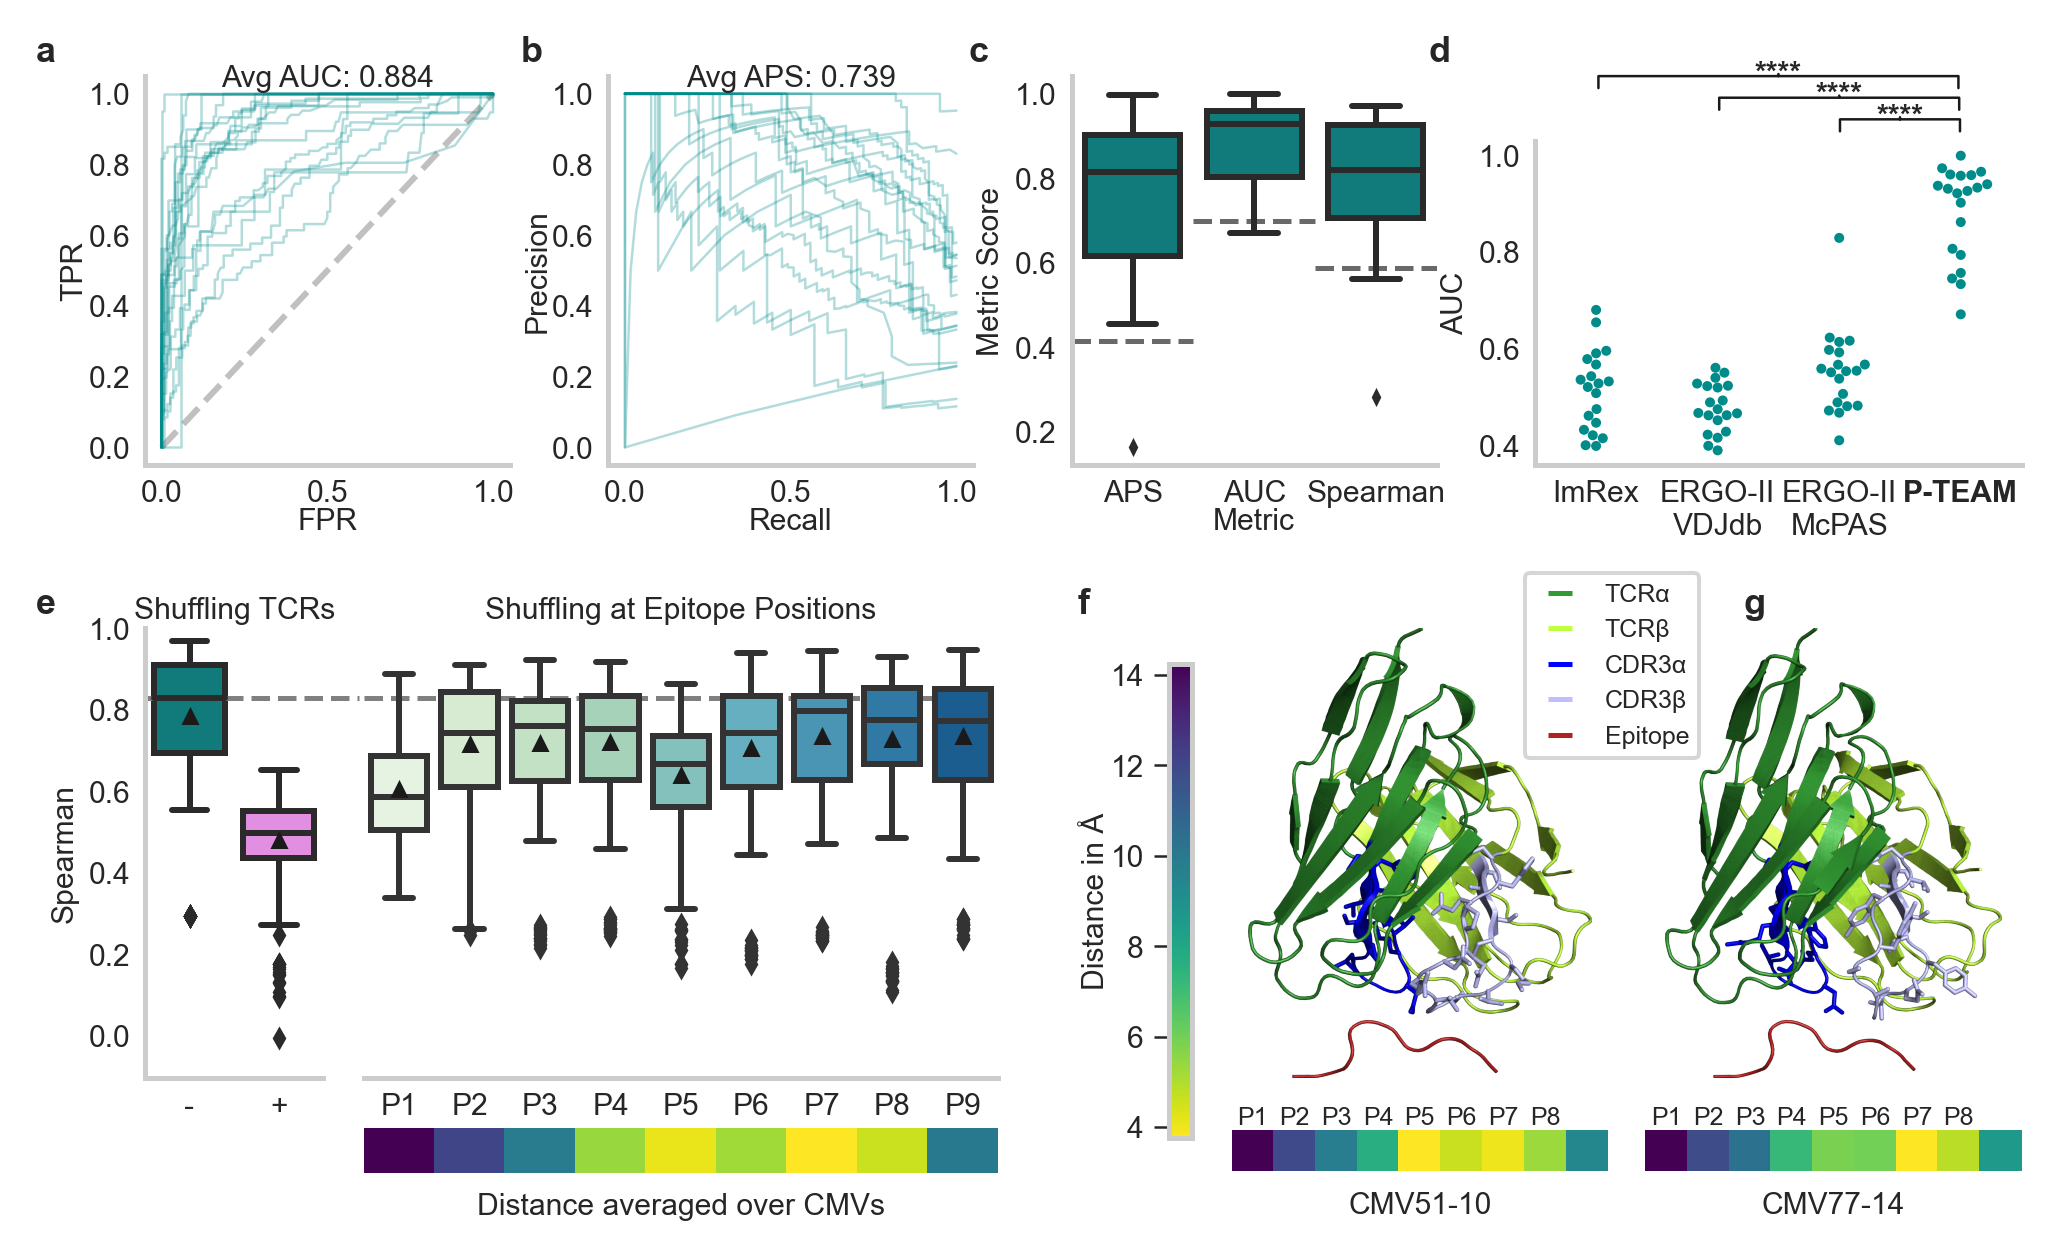

In [37]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.6), dpi=DPI)


gridspecs = {}
axes = {}

gridspecs['gs_full'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[0.25, 0.35],
    hspace=0.35,
)

gridspecs['gs_1-4'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_full'][0],
    nrows=1,
    ncols=4,
    width_ratios=[0.75, 0.75, 0.75, 1],
    wspace=0.25,
)

gridspecs['gs_4'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_1-4'][3],
    nrows=2,
    ncols=1,
    height_ratios=[0.2, 1],
    hspace=0
)

axes[f'ax_a'] = fig.add_subplot(gridspecs['gs_1-4'][0])
axes[f'ax_b'] = fig.add_subplot(gridspecs['gs_1-4'][1])
axes[f'ax_c'] = fig.add_subplot(gridspecs['gs_1-4'][2])

axes[f'ax_d_sign'] = fig.add_subplot(gridspecs['gs_4'][0])
axes[f'ax_d'] = fig.add_subplot(gridspecs['gs_4'][1])

plot_auc(pdf_classification[pdf_classification['Repertoire']=='CMV'], axes['ax_a'], ylabel='TPR', xlabel='FPR')
plot_auc(pdf_classification[pdf_classification['Repertoire']=='CMV'], axes['ax_b'], ylabel='Precision', xlabel='Recall',
         metric_func=metrics.precision_recall_curve,
         metric_name='APS')
plot_metric_boxplot(['APS', 'AUC', 'Spearman'], axes['ax_c'])
plot_baseline_data(performance_baseline, axes['ax_d'])
plot_significance(axes['ax_d_sign'])

axes['ax_c'].axhline(y=df_rdm['APS'].mean(), xmin=0, xmax=0.333, color='dimgrey', linestyle='--', linewidth=1, zorder=0)
axes['ax_c'].axhline(y=df_rdm['AUC'].mean(), xmin=0.333, xmax=0.666, color='dimgrey', linestyle='--', linewidth=1, zorder=0)
axes['ax_c'].axhline(y=df_rdm['Spearman'].mean(), xmin=0.666, xmax=1, color='dimgrey', linestyle='--', linewidth=1, zorder=0)


# Structural modelling
tcr_mice = ('TCR51-10', 'TCR77-14')
vmin = min([d.min() for d in dists_cmv.values()])
vmax = max([d.max() for d in dists_cmv.values()])

gridspecs['gs5-13'] = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gridspecs['gs_full'][1],
        nrows=1,
        ncols=2,
        width_ratios=[1, 1],
        wspace=0.2
)

gridspecs['gs5-8'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs5-13'][1],
    nrows=1,
    ncols=2,
    width_ratios=[0.20, 1],
    wspace=-0.2,
    #hspace=-0.15
)  

gridspecs['gs6-8'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs5-8'][1],
    nrows=2,
    ncols=2,
    height_ratios=[10, 1],
    width_ratios=[1, 1],
    wspace=0.10
    #hspace=-0.15
)    
gridspecs['gs9-13'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs5-13'][0],
    nrows=2,
    ncols=2,
    height_ratios=[10, 1],
    width_ratios=[2.25, 8],
    wspace=0.1
)

axes['ax_5'] = fig.add_subplot(gridspecs['gs5-8'][0])
axes['ax_6'] = fig.add_subplot(gridspecs['gs6-8'][0])
axes['ax_7'] = fig.add_subplot(gridspecs['gs6-8'][1])
axes['ax_8'] = fig.add_subplot(gridspecs['gs6-8'][2])
axes['ax_9'] = fig.add_subplot(gridspecs['gs6-8'][3])
axes['ax_10'] = fig.add_subplot(gridspecs['gs9-13'][0])
axes['ax_11'] = fig.add_subplot(gridspecs['gs9-13'][1])
axes['ax_12'] = fig.add_subplot(gridspecs['gs9-13'][2])
axes['ax_13'] = fig.add_subplot(gridspecs['gs9-13'][3])


palette_base = [palette_tcrs['CMV'], color_cdr3]

plot_colorbar(axes['ax_5'], epitope='NLVPMVATV', do_legend=False, do_left=True)
plot_3d_structures(axes['ax_7'], tcr_mice[1])
plot_3d_distances(axes['ax_8'], tcr_mice[0])
plot_3d_distances(axes['ax_9'], tcr_mice[1])
plot_3d_structures(axes['ax_6'], tcr_mice[0], do_legend=True)
axes['ax_6'].set_zorder(1)

plot_3d_distances(axes['ax_13'], 'avg', do_labels=False)
plot_permutation_importance_base(df_importance_cmv, axes['ax_10'], palette_base, do_heading=True)
plot_permutation_importance_position(df_importance_cmv, axes['ax_11'], palette=palette_cmv, do_heading=True)
axes['ax_12'].axis('off')

fig.text(0.08, 0.89, 'a', size='large', weight='bold')
fig.text(0.28, 0.89, 'b', size='large', weight='bold')
fig.text(0.465, 0.89, 'c', size='large', weight='bold')
fig.text(0.655, 0.89, 'd', size='large', weight='bold')

fig.text(0.08, 0.51, 'e', size='large', weight='bold')
fig.text(0.51, 0.51, 'f', size='large', weight='bold')
fig.text(0.785, 0.51, 'g', size='large', weight='bold')

fig.tight_layout()
fig.savefig('figures/manuscript_fig6_generalizationCMV.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_fig6_generalizationCMV.png', dpi=DPI, bbox_inches='tight')

## Figure S6

## Statistics for the paper

In [38]:
df_importance_cmv.groupby('Permutation')['Spearman'].mean()

Permutation
-       0.782682
CDR3    0.478992
P1      0.603830
P2      0.713942
P3      0.716218
P4      0.718616
P5      0.637957
P6      0.704611
P7      0.734377
P8      0.726307
P9      0.733931
Name: Spearman, dtype: float64

In [39]:
0.478992-0.782682

-0.30369

In [40]:
df_regression_metrics['Spearman'].mean()

0.7875489207945954

In [41]:
print('\nauc summary cmv\n',
    df_classification_metrics.groupby('Repertoire').describe().T
)

metrics_class_cmv = df_classification_metrics[df_classification_metrics['Repertoire']=='CMV']

print('\nbest cmv\n', metrics_class_cmv.sort_values('AUC').tail(3))
print('\nworst cmv\n', metrics_class_cmv.sort_values('AUC').head(3))

print('\nbelow random\n', df_classification_metrics.query('AUC < 0.5').sort_values('AUC'))



auc summary cmv
 Repertoire         CMV
index count  20.000000
      mean    9.500000
      std     5.916080
      min     0.000000
      25%     4.750000
      50%     9.500000
      75%    14.250000
      max    19.000000
AUC   count  20.000000
      mean    0.884059
      std     0.096624
      min     0.671130
      25%     0.803683
      50%     0.928922
      75%     0.958484
      max     0.999669
APS   count  20.000000
      mean    0.739289
      std     0.210187
      min     0.162782
      25%     0.615927
      50%     0.815270
      75%     0.901128
      max     0.997619

best cmv
    index      tcr       AUC       APS Repertoire
4      4   TCR3-4  0.966460  0.626546        CMV
1      1  TCR10-4  0.973570  0.916427        CMV
5      5   TCR4-4  0.999669  0.997619        CMV

worst cmv
     index       tcr       AUC       APS Repertoire
16     16  TCR81-14  0.671130  0.565714        CMV
11     11   TCR65-8  0.733656  0.584068        CMV
14     14  TCR74-14  0.745280  0.45

In [42]:
print('Paired t-test between P-TEAM and baseline models on AUC:')
for col in ['ergo-mcpas', 'ergo-vdjdb', 'imrex']:
    res = stats.ttest_rel(performance_baseline[col], performance_baseline['P-TEAM'])
    print(f'{col}: {res}')
    
print('\nPaired t-test between P-TEAM and baseline models on Spearman:')
for col in ['ergo-mcpas', 'ergo-vdjdb', 'imrex']:
    res = stats.ttest_rel(performance_baseline_regression[col], performance_baseline_regression['P-TEAM'])
    print(f'{col}: {res}')

Paired t-test between P-TEAM and baseline models on AUC:
ergo-mcpas: Ttest_relResult(statistic=-12.329857513380949, pvalue=1.6366522121612228e-10)
ergo-vdjdb: Ttest_relResult(statistic=-16.60472396150849, pvalue=9.093256371156066e-13)
imrex: Ttest_relResult(statistic=-12.620875299669498, pvalue=1.1000668429790036e-10)

Paired t-test between P-TEAM and baseline models on Spearman:
ergo-mcpas: Ttest_relResult(statistic=-19.00828155793519, pvalue=8.01120164652119e-14)
ergo-vdjdb: Ttest_relResult(statistic=-18.85766901351398, pvalue=9.251073617843213e-14)
imrex: Ttest_relResult(statistic=-14.243075020418884, pvalue=1.3635986961203523e-11)


In [43]:
print('Mean performance of the baseline models (AUC):')
print(performance_baseline.mean())

Mean performance of the baseline models (AUC):
ergo-mcpas    0.553407
ergo-vdjdb    0.478077
imrex         0.514067
P-TEAM        0.884059
dtype: float64


In [44]:
df_classification_metrics[['tcr', 'AUC', 'APS']].sort_values('tcr').round(3)

,tcr,AUC,APS
0,TCR1-4,0.807,0.485
1,TCR10-4,0.974,0.916
2,TCR11-4,0.961,0.954
3,TCR2-4,0.862,0.710
4,TCR3-4,0.966,0.627
5,TCR4-4,1.000,0.998
6,TCR5-2,0.902,0.903
7,TCR51-10,0.940,0.163
8,TCR52-10,0.959,0.830
9,TCR54-10,0.937,0.801


In [45]:
df_regression_metrics[['tcr', 'Spearman']].sort_values('tcr').round(3).sort_values('Spearman')

,tcr,Spearman
16,TCR81-14,0.282
14,TCR74-14,0.561
0,TCR1-4,0.610
10,TCR6-2,0.632
11,TCR65-8,0.666
7,TCR51-10,0.719
18,TCR83-3,0.735
4,TCR3-4,0.782
3,TCR2-4,0.798
6,TCR5-2,0.809


# Supplement Structures

<ipython-input-46-784ac7d595ca>:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


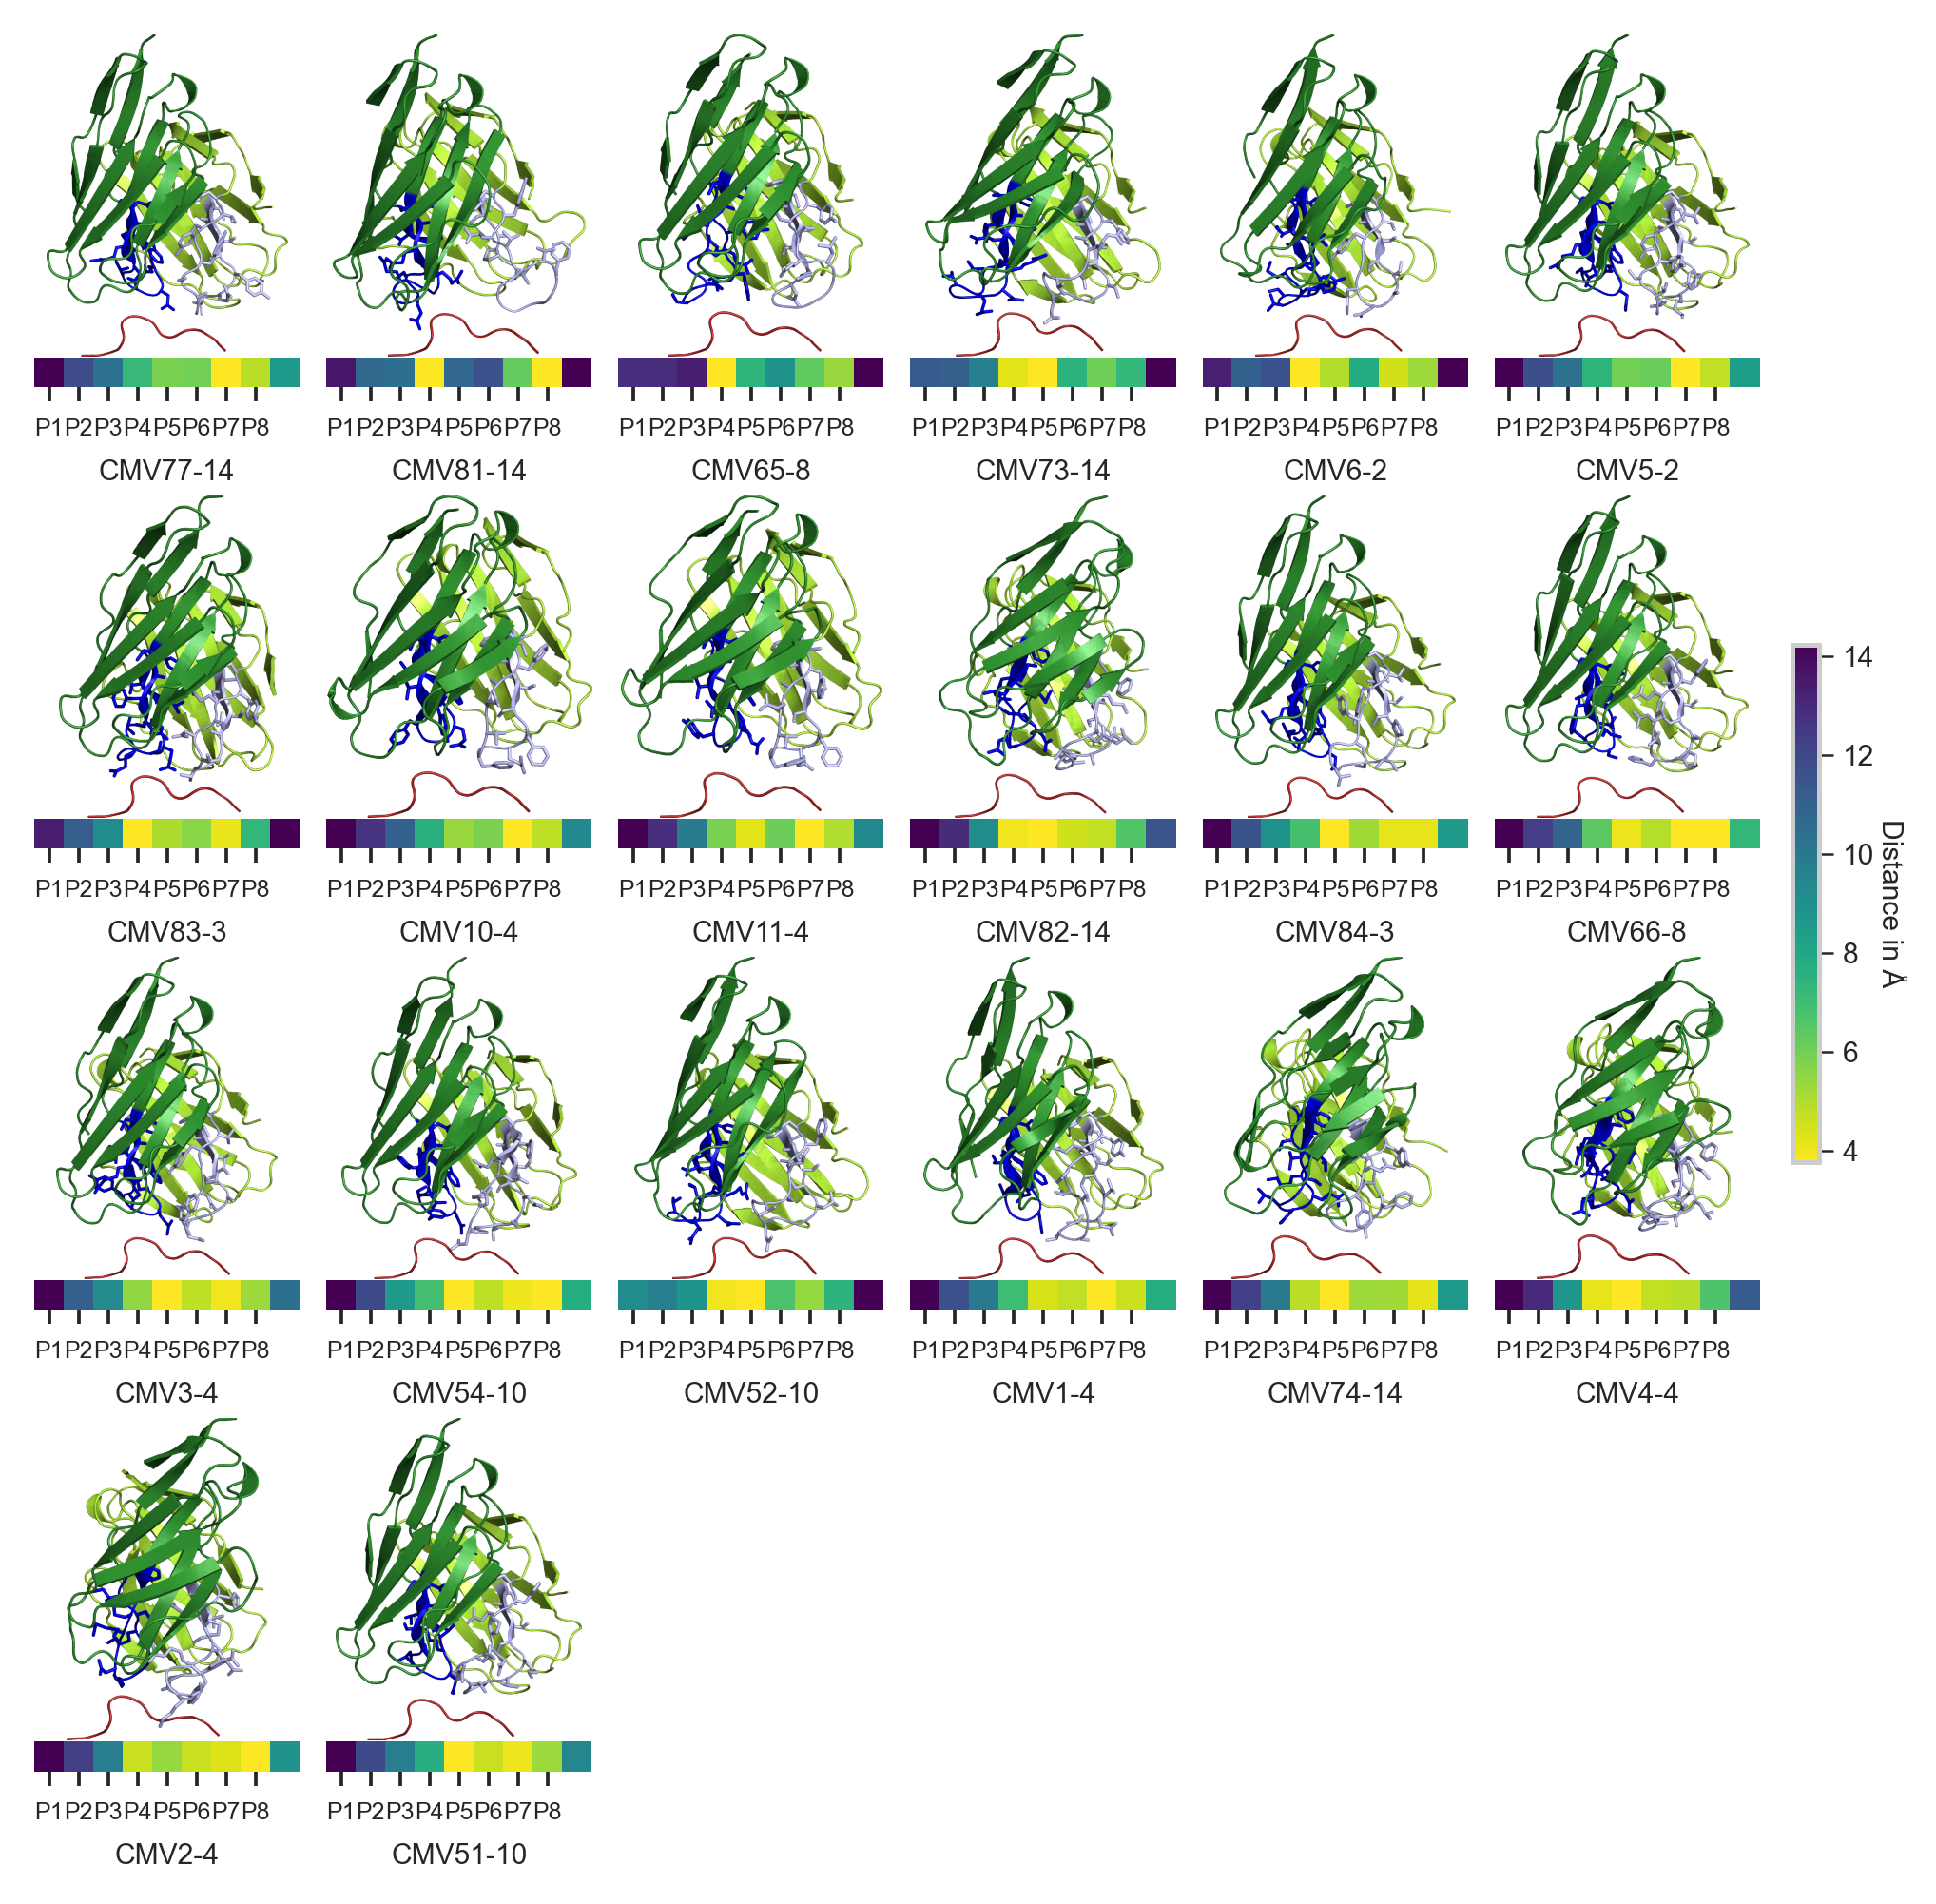

In [46]:
n_cols = 6
n_rows = (len(vis_names_cmv)-1)//6 + 1

fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.25 * n_rows), dpi=DPI)
gridspecs = {}
axes = {}


gs = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    width_ratios=[10, 1],
    wspace=-0.12,
)

gs_vis = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gs[0],
    nrows=n_rows,
    ncols=n_cols,
    height_ratios=[1]*n_rows,
    width_ratios=[1] * n_cols,
    wspace=0.1,
    hspace=0.3 # 0.2
)

ax_cb = fig.add_subplot(gs[1])
plot_colorbar(ax_cb, 'NLVPMVATV')

# Sorted by reactivity to NLV
vis_names_cmv = ['TCR77-14', 'TCR81-14', 'TCR65-8', 'TCR73-14', 'TCR6-2', 'TCR5-2',
       'TCR83-3', 'TCR10-4', 'TCR11-4', 'TCR82-14', 'TCR84-3', 'TCR66-8',
       'TCR3-4', 'TCR54-10', 'TCR52-10', 'TCR1-4', 'TCR74-14', 'TCR4-4',
       'TCR2-4', 'TCR51-10']

for i, tcr in enumerate(vis_names_cmv):
    row = i//n_cols
    col = i%n_cols
    gs_tcr = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gs_vis[i],
        nrows=2,
        ncols=1,
        height_ratios=[1, 0.1],
        hspace=-0.
    )
    ax_struc = fig.add_subplot(gs_tcr[0])
    plot_3d_structures(ax_struc, tcr)
    
    ax_dists = fig.add_subplot(gs_tcr[1])
    plot_3d_distances(ax_dists, tcr, legend_top=False)
    
    #fig.text(0.125 + 0.127*col, 0.87-row*0.129, abc[i], size='large', weight='bold')
    
fig.tight_layout()
fig.savefig('figures/manuscript_supp_3dModelCMV.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_supp_3dModelCMV.png', dpi=DPI, bbox_inches='tight')

# Stats for paper

In [47]:
dists_cmv_avg = np.vstack([dist for tcr, dist in dists_cmv.items()]).mean(axis=0)
dists_cmv_avg = pd.DataFrame(data=dists_cmv_avg, index=[f'P{i+1}' for i in range(9)], columns=['distance'])

df_importance_cmv_avg = df_importance_cmv.groupby(['Permutation']).mean().sort_values('Spearman')
df_importance_cmv_avg = pd.concat([df_importance_cmv_avg, dists_cmv_avg], axis=1)
df_importance_cmv_avg

,Spearman,base,diff,rel,distance
CDR3,0.478992,0.782682,-0.303690,-0.381080,NaN
P1,0.603830,0.782682,-0.178852,-0.204086,11.435146
P5,0.637957,0.782682,-0.144725,-0.179990,5.055214
P6,0.704611,0.782682,-0.078071,-0.108240,5.767751
P2,0.713942,0.782682,-0.068740,-0.087678,10.086122
P3,0.716218,0.782682,-0.066465,-0.087207,8.683922
P4,0.718616,0.782682,-0.064067,-0.079856,5.863103
P8,0.726307,0.782682,-0.056375,-0.085259,5.349759
P9,0.733931,0.782682,-0.048751,-0.066429,8.766033
P7,0.734377,0.782682,-0.048306,-0.065230,4.832427


In [48]:
print('CMV: correlation and p-value between Spearman and distance')
df_cmv_pos = df_importance_cmv_avg[df_importance_cmv_avg.index.str.startswith('P')]
stats.pearsonr(df_cmv_pos['Spearman'], df_cmv_pos['distance'])

CMV: correlation and p-value between Spearman and distance


(-0.3507794926708545, 0.35467505586895093)

In [49]:
dists_cmv_df = np.vstack([dist for tcr, dist in dists_cmv.items()]).transpose()
dists_cmv_df = pd.DataFrame(data=dists_cmv_df, 
                               index=[f'P{i+1}' for i in range(9)], 
                               columns=dists_cmv.keys())
dists_cmv_df

,TCR1-4,TCR10-4,TCR11-4,TCR2-4,TCR3-4,TCR4-4,TCR5-2,TCR51-10,TCR52-10,TCR54-10,TCR6-2,TCR65-8,TCR66-8,TCR73-14,TCR74-14,TCR77-14,TCR81-14,TCR82-14,TCR83-3,TCR84-3
P1,13.298136,12.838975,12.460961,11.147195,13.078362,12.108394,13.784793,13.606572,6.992326,14.240708,8.396713,7.575212,13.520578,7.678620,12.131360,13.627496,7.438134,11.997319,9.160248,13.620811
P2,10.993920,11.582532,11.433057,9.870089,10.796199,11.221502,11.371907,11.414563,7.254233,12.113914,7.449312,7.601540,12.189962,7.594647,10.769278,11.369032,6.422614,11.096835,7.911496,11.265820
P3,9.461936,10.323169,9.249315,8.251494,9.485876,8.196748,10.104271,9.495556,6.784119,8.978564,7.687556,7.766878,11.177694,6.906798,9.218239,9.964080,6.333296,8.456627,6.888321,8.947895
P4,6.808390,7.566337,6.281058,4.837428,6.760228,4.869445,7.267914,7.464205,4.371220,7.430104,4.373508,4.346968,8.002106,4.236903,5.726382,7.063457,3.957992,4.840848,3.926669,7.130901
P5,4.417245,5.805446,5.083310,5.348849,5.487240,4.601055,5.898338,3.827716,4.258159,4.539597,4.889863,5.658475,6.357822,4.008275,4.984559,5.796287,6.449313,4.679853,4.612419,4.400468
P6,4.759215,6.171254,6.473488,4.842482,6.251264,5.301582,6.061070,4.667081,5.737179,5.506646,6.085123,6.189853,6.975054,5.825828,6.017875,5.895977,6.752282,5.234830,4.899841,5.707084
P7,3.855581,4.535403,4.722207,4.622829,5.652031,5.399838,3.766024,4.079774,5.104443,4.800516,4.687259,5.260628,6.164989,5.142827,5.998720,3.802988,4.817467,5.358079,4.121681,4.755263
P8,4.603035,5.348849,5.644978,4.258271,6.600979,6.695810,4.734590,5.306643,6.116745,4.597466,5.013831,4.928806,6.155697,5.714942,5.269836,4.806463,3.936664,6.667331,5.863636,4.730613
P9,7.438223,8.936532,8.860229,7.599164,10.292829,9.985579,8.238017,9.090821,9.507246,8.230588,8.785431,8.077804,8.663309,9.111698,8.288241,8.297250,7.666876,10.062985,9.585949,8.601883


## Class on Reg

In [50]:
pdf_classification['abserr'] = 0
df_regbin_metrics = pdf_classification.groupby(['tcr'], as_index=False).apply(compute_regression_metrics).reset_index()
df_regbin_metrics['Repertoire'] = 'CMV'
df_regbin_metrics['Train_classification'] = True
df_regression_metrics['Train_classification'] = False
df_regbin_metrics = pd.concat([df_regbin_metrics, df_regression_metrics])
df_regbin_metrics.groupby(['Train_classification', 'Repertoire'])['Spearman'].mean()

Train_classification  Repertoire
False                 CMV           0.787549
True                  CMV           0.687205
Name: Spearman, dtype: float64

Text(0.5, 0.98, 'Regression Metrics')

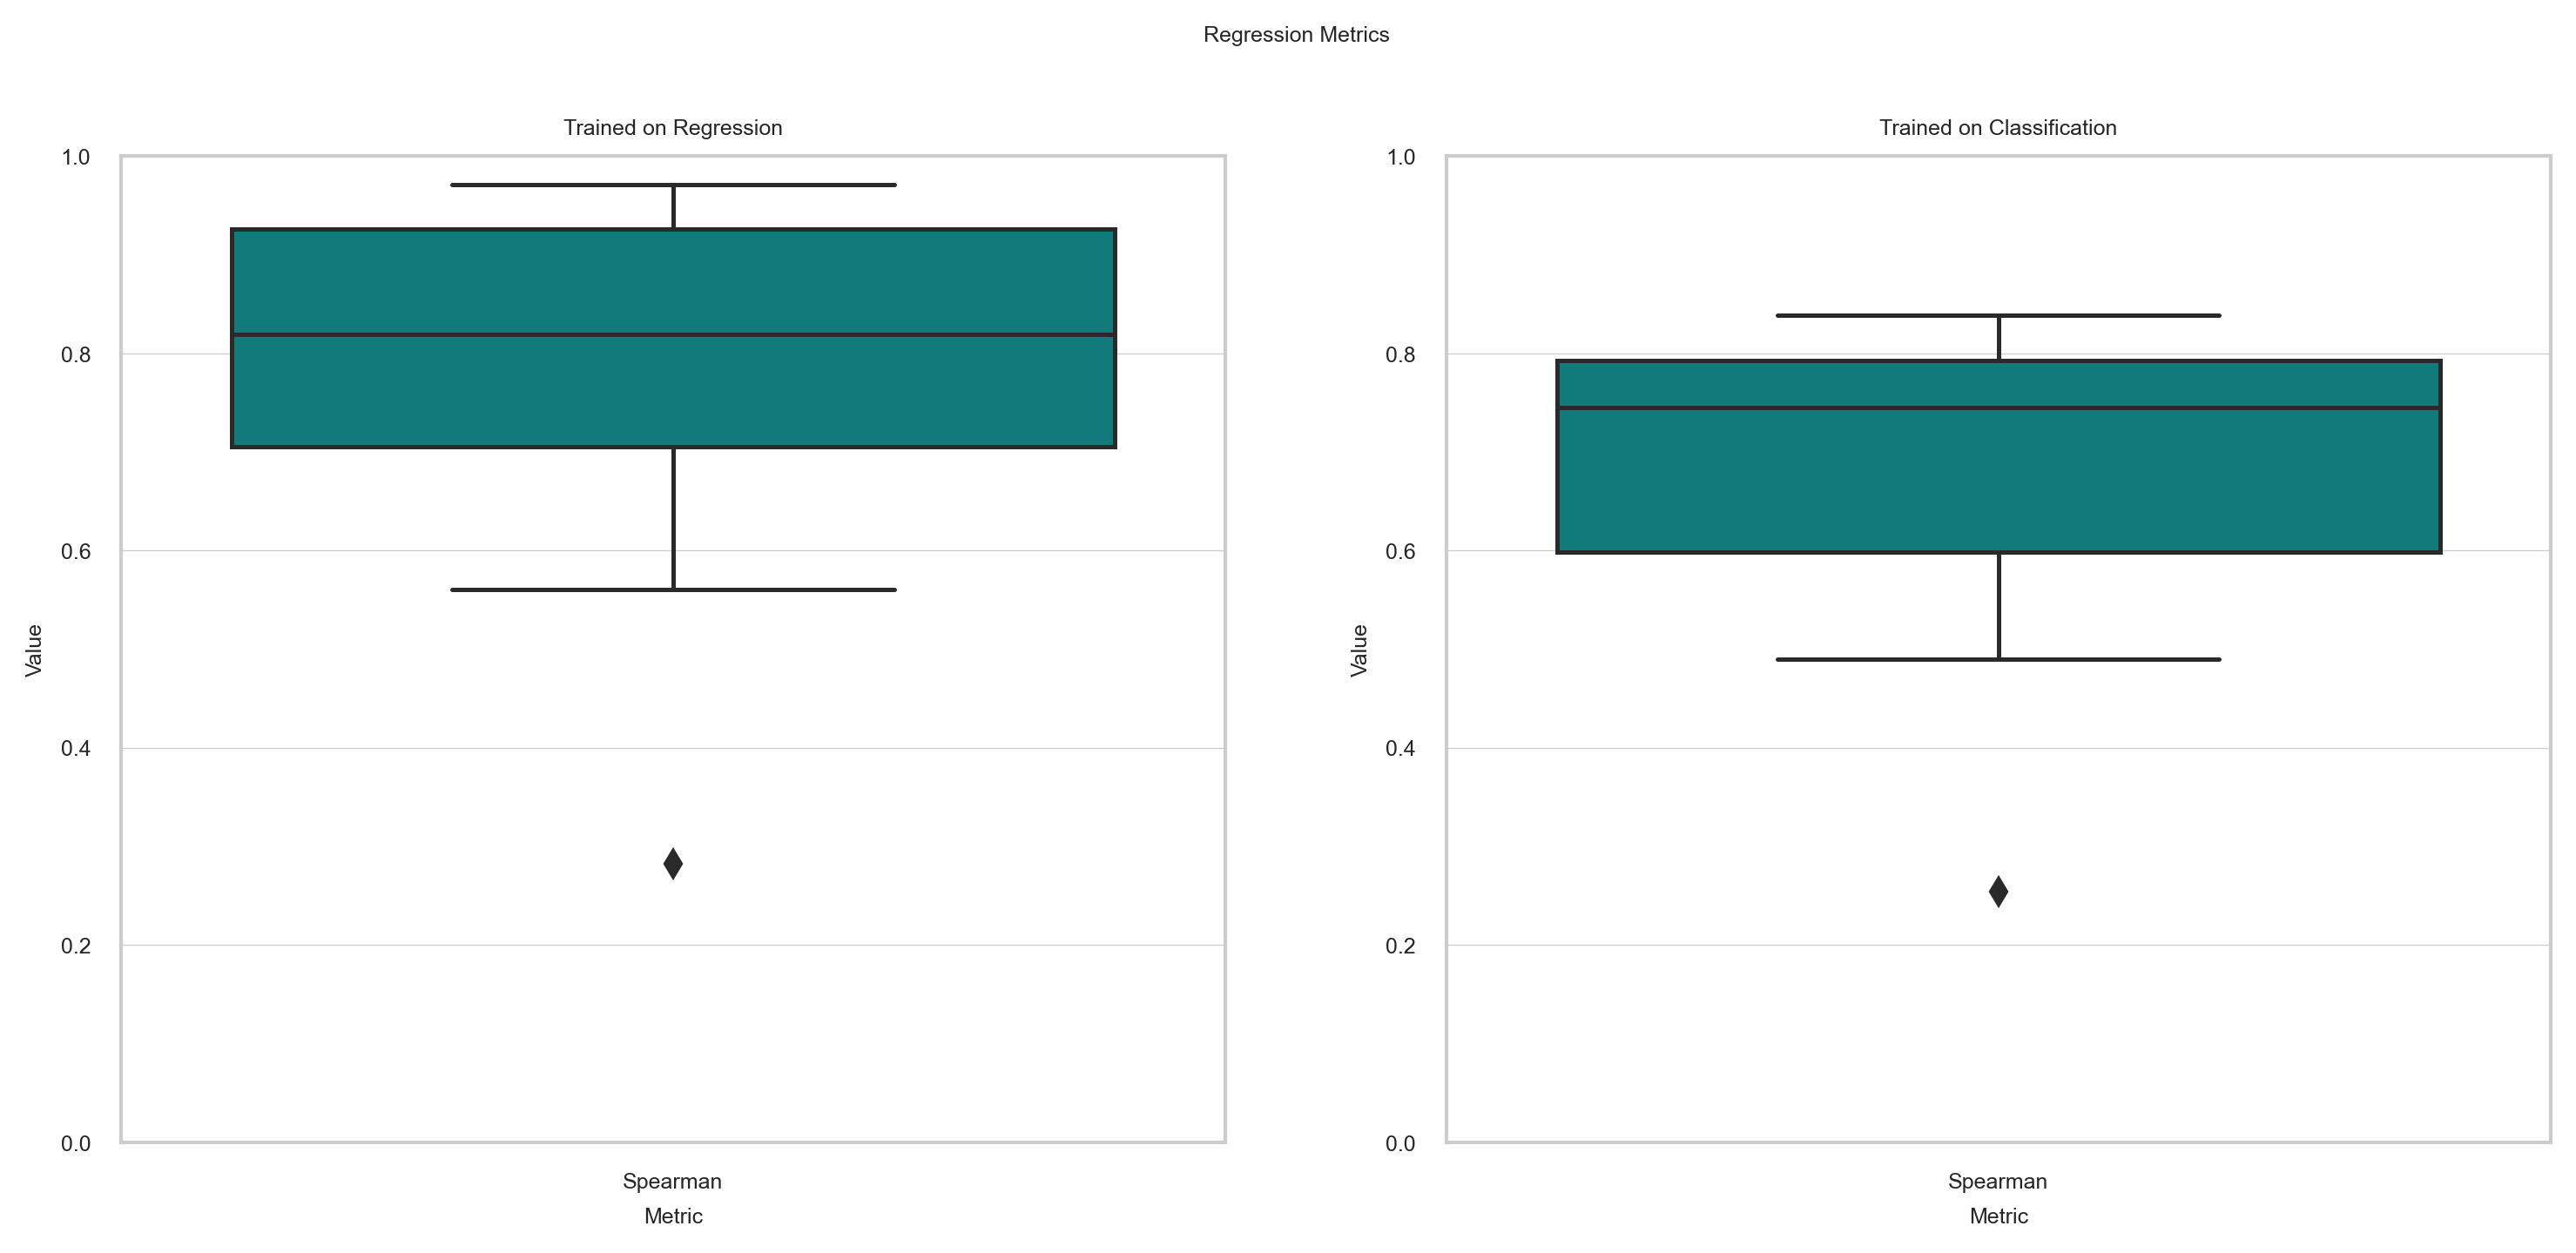

In [51]:
df_plot = df_regbin_metrics[['tcr', 'Repertoire', 'Train_classification', 'Spearman']].copy()
df_plot = df_plot.melt(['tcr', 'Repertoire', 'Train_classification'], value_name='Value', var_name='Metric')

fig = plt.figure(figsize=(12,  5), dpi=300)
gridspecs = {}
axes = {}

gridspecs['gs_1-2'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    #wspace=0.1,
    hspace=0.25,
)

ax_false = fig.add_subplot(gridspecs['gs_1-2'][0])
ax_true = fig.add_subplot(gridspecs['gs_1-2'][1])
sb.boxplot(data=df_plot[df_plot['Train_classification']], x='Metric', y='Value', ax=ax_true, color='darkcyan')
sb.boxplot(data=df_plot[~df_plot['Train_classification']], x='Metric', y='Value', ax=ax_false, color='darkcyan')
ax_false.set_ylim(0, 1)
ax_false.set_title('Trained on Regression')
ax_true.set_ylim(0, 1)
ax_true.set_title('Trained on Classification')
fig.suptitle('Regression Metrics')

## Positionwise evaluation

In [52]:
def compute_class_score(g):
    return pd.Series({
        'Accuracy': (metrics.accuracy_score(g['is_activated'], g['pred_bin'])),
    })
pdf_classification['pred_bin'] = pdf_classification['pred'] > 0.5

In [53]:
acc = pdf_classification.groupby(['tcr', 'mut_pos']) \
        .apply(compute_class_score).reset_index()
#acc = acc.rename(columns={0: 'Accuracy'})
acc['Repertoire'] = 'CMV'
acc['mut_pos'] = acc['mut_pos'] + 1
acc.groupby('Repertoire')['Accuracy'].mean()

Repertoire
CMV    0.82924
Name: Accuracy, dtype: float64

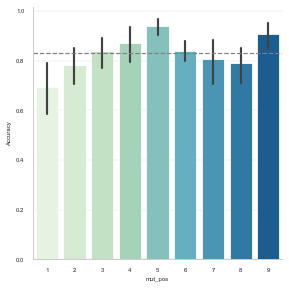

In [54]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
sb.barplot(data=acc, y='Accuracy', x='mut_pos', ax=axes, palette='GnBu')
sb.despine(ax=axes)
axes.axhline(acc['Accuracy'].mean(), color='gray', linestyle='--')
plt.tight_layout()
plt.show()